# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [1]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

fatal: destination path 'GroceryStoreDataset' already exists and is not an empty directory.


## Imports and cuda

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
from PIL import Image
from typing import List, Tuple
import copy
import random

import torch
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Dataset exploration

In [3]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split # used for splitting the dataset in train and test
        self.paths, self.labels = self.read_file() #reading the labels and images

        self.transform = transform 

    def __len__(self) -> int: #get the number of elements in the dataset
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]: 
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    # legge un file di testo che contiene i percorsi delle immagini e le etichette associate
    # restituisce due liste: una con percorsi delle immagini e una con le etichette
    def read_file(self) -> Tuple[List[str], List[int]]: #outputs a tuple
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ") #rimuove il carattere di nuova linea, e poi divide in 3 parti con virgola come separatore 
                paths.append(path), labels.append(int(label)) #salva solo percorsi ed etichette

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

In [4]:
train_dataset = GroceryStoreDataset(split="train")
test_dataset = GroceryStoreDataset(split="test")
val_dataset = GroceryStoreDataset(split="val")

### Dataset length

In [29]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 2640
Test dataset size: 2485
Validation dataset size: 296


### Visualize some samples of the dataset

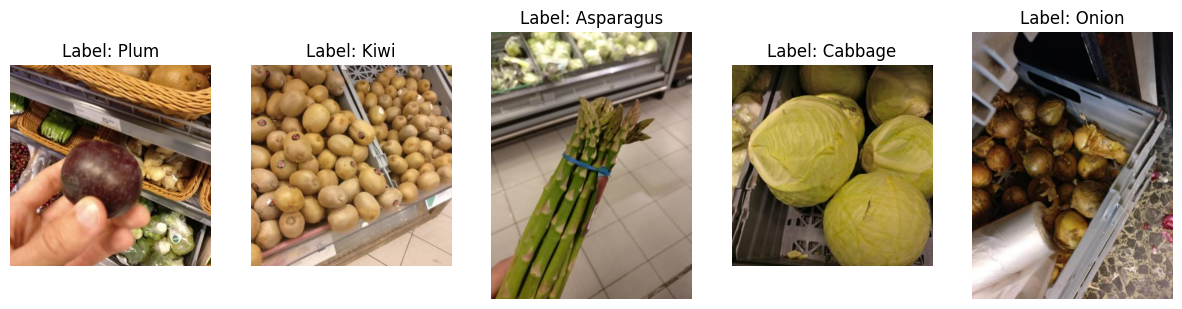

In [22]:
# Class labels mapping
CLASS_NAMES = [
    "Apple", "Avocado", "Banana", "Kiwi", "Lemon", "Lime", "Mango", "Melon", "Nectarine", 
    "Orange", "Papaya", "Passion-Fruit", "Peach", "Pear", "Pineapple", "Plum", "Pomegranate", 
    "Red-Grapefruit", "Satsumas", "Juice", "Milk", "Oatghurt", "Oat-Milk", "Sour-Cream", 
    "Sour-Milk", "Soyghurt", "Soy-Milk", "Yoghurt", "Asparagus", "Aubergine", "Cabbage", 
    "Carrots", "Cucumber", "Garlic", "Ginger", "Leek", "Mushroom", "Onion", "Pepper", "Potato", 
    "Red-Beet", "Tomato", "Zucchini"
]

def show_sample_images(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    transform = transforms.ToTensor()
    
    # Create a list of unique labels in the dataset
    unique_labels = list(set(label for _, label in dataset))
    random.shuffle(unique_labels)
    
    # Select num_samples unique labels
    selected_labels = unique_labels[:num_samples]
    
    for i, label in enumerate(selected_labels):
        # Find the first image with the selected label
        for img, img_label in dataset:
            if img_label == label:
                img_tensor = transform(img)  # Convert PIL image to tensor
                axes[i].imshow(img_tensor.permute(1, 2, 0))  # Permute to HWC
                axes[i].set_title(f"Label: {CLASS_NAMES[label]}")
                axes[i].axis('off')
                break
    
    plt.show()

# Show sample images from the train dataset
show_sample_images(train_dataset, num_samples=5)

### Check image sizes

In [27]:
def check_image_sizes(dataset, dataset_name):
    sizes = set()
    
    for img, _ in dataset:
        sizes.add(img.size)
    
    print(f"Unique image sizes for {dataset_name}:")
    for size in sizes:
        print(f"- {size}")
    print("\n")

check_image_sizes(train_dataset, "train_dataset")
check_image_sizes(test_dataset, "test_dataset")
check_image_sizes(val_dataset, "val_dataset")

Unique image sizes for train_dataset:
- (348, 464)
- (464, 348)
- (348, 348)


Unique image sizes for test_dataset:
- (348, 464)
- (464, 348)
- (348, 348)


Unique image sizes for val_dataset:
- (348, 348)




### Class distribution

In [34]:
print(f"Number of classes in the train dataset: {train_dataset.get_num_classes()}")
print(f"Number of classes in the test dataset: {test_dataset.get_num_classes()}")
print(f"Number of classes in the validation dataset: {val_dataset.get_num_classes()}")

if train_dataset.get_num_classes() == test_dataset.get_num_classes() == val_dataset.get_num_classes():
    print("Number of classes is consistent across datasets")
else:
    print("Number of classes is not consistent across datasets")

Number of classes in the train dataset: 43
Number of classes in the test dataset: 43
Number of classes in the validation dataset: 43
Number of classes is consistent across datasets


In [30]:
def get_class_distribution(dataset):
    labels = [label for _, label in dataset]
    distribution = Counter(labels)
    return distribution

train_distribution = get_class_distribution(train_dataset)
test_distribution = get_class_distribution(test_dataset)
val_distribution = get_class_distribution(val_dataset)

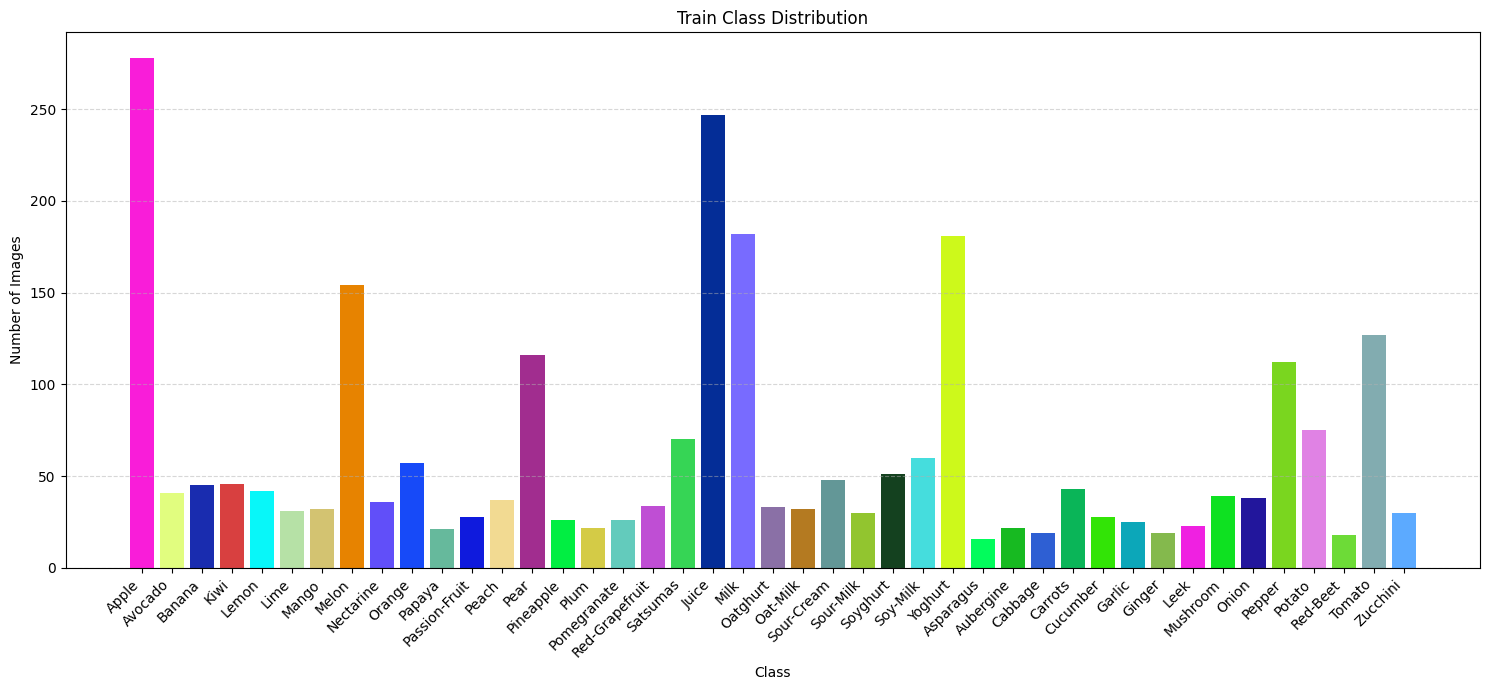

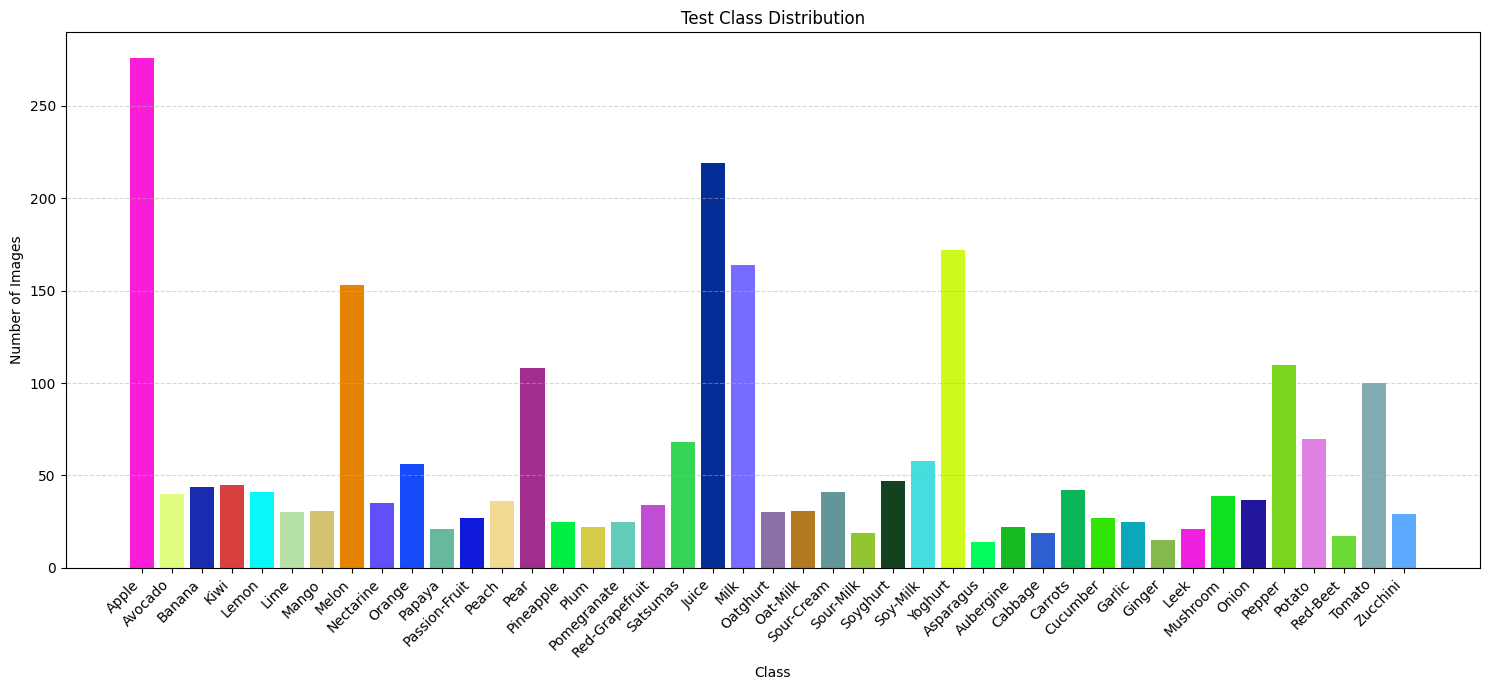

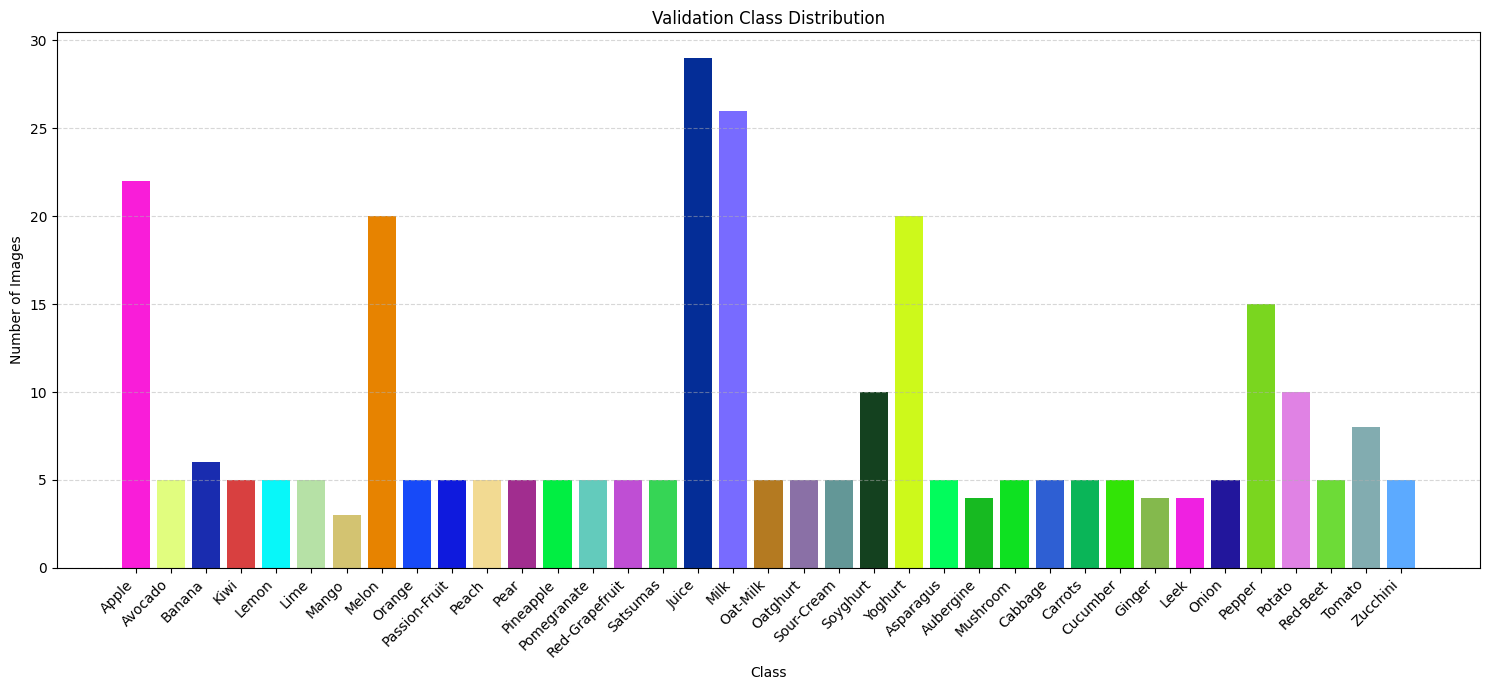

In [18]:
# Pre-generate consistent colors for each class
def generate_class_colors():
    np.random.seed(42)  # Ensure reproducibility
    colors = [f"#{random.randint(0, 0xFFFFFF):06x}" for _ in CLASS_NAMES]
    return colors

# Create a dictionary of class indices and their corresponding colors
CLASS_COLORS = generate_class_colors()

def plot_class_distribution(distribution, title):
    class_indices = list(distribution.keys())
    class_counts = list(distribution.values())
    class_labels = [CLASS_NAMES[idx] for idx in class_indices]
    colors = [CLASS_COLORS[idx] for idx in class_indices]
    
    plt.figure(figsize=(15, 7))
    plt.bar(class_labels, class_counts, color=colors)
    plt.xticks(rotation=45, ha="right")
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()  # Adjust layout to make room for the plot
    plt.show()

plot_class_distribution(train_distribution, "Train Class Distribution")
plot_class_distribution(test_distribution, "Test Class Distribution")
plot_class_distribution(val_distribution, "Validation Class Distribution")


## Image resizing  

Since images don't have the same size we will resize them. We choose (224, 224) for simplicity for part 2 in which we will have to train a ResNet-18. 

In [41]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [42]:
train_dataset = GroceryStoreDataset(split="train", transform=transform)
test_dataset = GroceryStoreDataset(split="test", transform=transform)
val_dataset = GroceryStoreDataset(split="val", transform=transform)

Check new sizes after resizing

In [44]:
def check_image_sizes(dataset, dataset_name):
    sizes = set()
    
    for img, _ in dataset:
        sizes.add(tuple(img.shape))
    
    print(f"Unique image sizes for {dataset_name}:")
    for size in sizes:
        print(f"- {size}")
    print("\n")

check_image_sizes(train_dataset, "train_dataset")
check_image_sizes(test_dataset, "test_dataset")
check_image_sizes(val_dataset, "val_dataset")

Unique image sizes for train_dataset:
- (3, 224, 224)


Unique image sizes for test_dataset:
- (3, 224, 224)


Unique image sizes for val_dataset:
- (3, 224, 224)




## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

## First convolutional neural network

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FirstCNN(nn.Module):
    def __init__(self, num_classes=43):
        super(FirstCNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(16)  # BatchNorm after conv1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(32)  # BatchNorm after conv2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)  # BatchNorm after conv3
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Determining the input size to the fully connected layer
        self._to_linear = None
        self._compute_linear_input(torch.randn(1, 3, 224, 224))  # Simulate a forward pass
        
        # fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, 84)
        self.fc3 = nn.Linear(84, num_classes)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def _compute_linear_input(self, x):
        """Method to determine the flattened input size after convolutions."""
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        self._to_linear = x.view(-1).shape[0]

    def forward(self, x):
        # Passing through convolutional layers
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten, fully connected layers, and dropout
        x = x.view(-1, self._to_linear)
        
        # Passing through the fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
first_cnn= FirstCNN()
first_cnn.to(device)
summary(first_cnn, input_size=(3, 224, 224), device="cuda" if torch.cuda.is_available() else "cpu")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
       BatchNorm2d-2         [-1, 16, 220, 220]              32
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
       BatchNorm2d-5         [-1, 32, 106, 106]              64
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Conv2d-7           [-1, 64, 53, 53]          18,496
       BatchNorm2d-8           [-1, 64, 53, 53]             128
         MaxPool2d-9           [-1, 64, 26, 26]               0
           Linear-10                  [-1, 128]       5,537,920
          Dropout-11                  [-1, 128]               0
           Linear-12                   [-1, 84]          10,836
           Linear-13                   [-1, 43]           3,655
Total params: 5,585,179
Trainable param

### Hyperparameters

In [47]:
BATCH_SIZE = 32
NUM_EPOCHS =30
PATIENCE = 7

### Data loader

In [48]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Train Function

In [49]:
def train_model(model, train_loader, val_loader, num_epochs, patience):
    # Loss function
    loss_fn = nn.CrossEntropyLoss()
    # Optimizer
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)
    # Scheduler
    scheduler = StepLR(optimizer, step_size=7, gamma=0.1)


    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    early_stop_counter = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):

        # Initialize metrics for this epoch
        epoch_train_loss = 0.0
        epoch_train_acc = 0.0
        epoch_val_loss = 0.0
        epoch_val_acc = 0.0

        # Training phase
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = running_corrects.double() / len(train_loader.dataset)

        # Validation phase
        model.eval()   # Set model to evaluate mode
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                _, preds = torch.max(outputs, 1)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = running_corrects.double() / len(val_loader.dataset)

        # Print metrics
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | '
              f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        # Save losses and accuracies
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc.item())
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc.item())

        # Deep copy the model if validation accuracy improves
        if epoch_val_loss <= best_loss:
            best_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        # Early stopping
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

        # Step the scheduler
        scheduler.step()

    print(f'Minimun val loss: {best_loss:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accuracies, val_losses, val_accuracies

### Actual Training 

In [50]:
first_cnn_model, first_train_losses, first_train_accuracies, first_val_losses, first_val_accuracies, = train_model(first_cnn, train_loader, val_loader, NUM_EPOCHS, PATIENCE)

Epoch [1/30], Train Loss: 3.4944 Acc: 0.1125 | Val Loss: 3.2580 Acc: 0.2669
Epoch [2/30], Train Loss: 3.0880 Acc: 0.2008 | Val Loss: 3.1163 Acc: 0.2264
Epoch [3/30], Train Loss: 2.8969 Acc: 0.2333 | Val Loss: 3.0059 Acc: 0.2635
Epoch [4/30], Train Loss: 2.7405 Acc: 0.2682 | Val Loss: 2.8535 Acc: 0.3041
Epoch [5/30], Train Loss: 2.6169 Acc: 0.2947 | Val Loss: 2.8470 Acc: 0.2601
Epoch [6/30], Train Loss: 2.4833 Acc: 0.3265 | Val Loss: 2.7546 Acc: 0.3007
Epoch [7/30], Train Loss: 2.3784 Acc: 0.3280 | Val Loss: 2.7651 Acc: 0.2601
Epoch [8/30], Train Loss: 2.2843 Acc: 0.3508 | Val Loss: 2.6722 Acc: 0.3277
Epoch [9/30], Train Loss: 2.2528 Acc: 0.3754 | Val Loss: 2.6737 Acc: 0.3209
Epoch [10/30], Train Loss: 2.2636 Acc: 0.3568 | Val Loss: 2.6704 Acc: 0.3209
Epoch [11/30], Train Loss: 2.2631 Acc: 0.3659 | Val Loss: 2.6699 Acc: 0.3412
Epoch [12/30], Train Loss: 2.2414 Acc: 0.3686 | Val Loss: 2.6658 Acc: 0.3074
Epoch [13/30], Train Loss: 2.2352 Acc: 0.3663 | Val Loss: 2.6380 Acc: 0.3378
Epoch [1

C:\Users\alessia\AppData\Local\Temp\4\ipykernel_13532\1847920282.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(epochs, train_losses, 'bo-', label='Train Loss', color='blue', marker='o')
C:\Users\alessia\AppData\Local\Temp\4\ipykernel_13532\1847920282.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, train_losses, 'bo-', label='Train Loss', color='blue', marker='o')
C:\Users\alessia\AppData\Local\Temp\4\ipykernel_13532\1847920282.py:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "go-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(epochs, val_losses, 'go-', label='Val Loss', color='green', marker='o')
C:\Users\alessia\AppData\Local\Temp\4\ipykernel_1

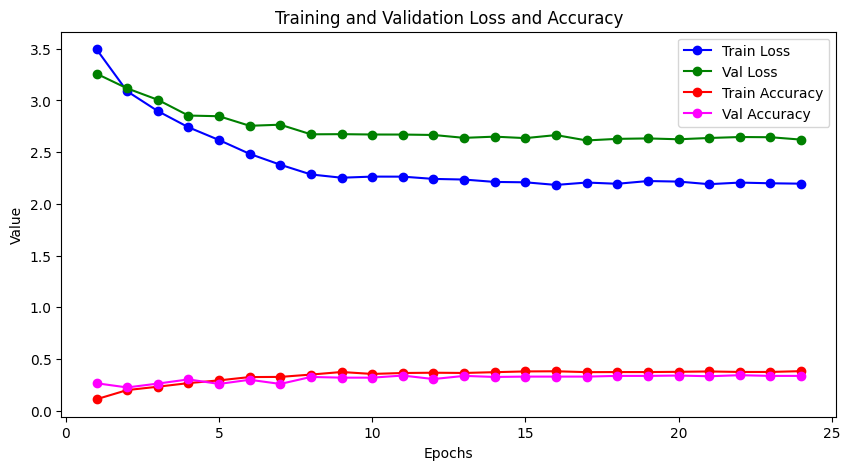

In [ ]:
import matplotlib.pyplot as plt
from typing import List

def plot_training_history(train_losses: List[float], val_losses: List[float], train_accuracies: List[float], val_accuracies: List[float]):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(10, 5))
    
    # Plot loss
    plt.plot(epochs, train_losses, 'bo-', label='Train Loss', color='blue', marker='o')
    plt.plot(epochs, val_losses, 'go-', label='Val Loss', color='green', marker='o')
    
    # Plot accuracy
    plt.plot(epochs, train_accuracies, 'ro-', label='Train Accuracy', color='red', marker='o')
    plt.plot(epochs, val_accuracies, 'mo-', label='Val Accuracy', color='magenta', marker='o')
    
    plt.title('Training and Validation Loss and Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    
    plt.show()

plot_training_history(first_train_losses, first_val_losses, first_train_accuracies, first_val_accuracies)

## Some other preprocessing: normalization

In [56]:
def calculate_mean_std(dataset, batch_size=64):
    """
    Calcola la media e la deviazione standard dei canali RGB di un dataset personalizzato.
    
    Args:
        dataset (Dataset): Istanza della classe GroceryStoreDataset.
        batch_size (int): Numero di campioni per batch nel DataLoader.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Mean e std dei canali RGB.
    """
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    mean = torch.zeros(3)  # Per i tre canali RGB
    std = torch.zeros(3)
    nb_samples = 0

    for data, _ in loader:
        batch_samples = data.size(0)  # Numero di immagini nel batch
        data = data.view(batch_samples, 3, -1)  # [B, C, H*W]
        
        mean += data.mean(2).sum(0)  # Sommiamo la media dei pixel per canale
        std += data.std(2).sum(0)    # Sommiamo la std dei pixel per canale
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples

    return mean, std

# Calculate mean and std
mean, std = calculate_mean_std(train_dataset)

print(f"Mean: {mean.tolist()}, Std: {std.tolist()}")


Mean: [0.5305869579315186, 0.3963676691055298, 0.25638359785079956], Std: [0.2292727828025818, 0.2059653103351593, 0.17461846768856049]


Applying the normalization

In [59]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset = GroceryStoreDataset(split="train", transform=transform)
test_dataset = GroceryStoreDataset(split="test", transform=transform)
val_dataset = GroceryStoreDataset(split="val", transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Training again the same cnn

In [60]:
first_cnn_model, first_train_losses, first_train_accuracies, first_val_losses, first_val_accuracies, = train_model(first_cnn, train_loader, val_loader, NUM_EPOCHS, PATIENCE)

Epoch [1/30], Train Loss: 2.2192 Acc: 0.3667 | Val Loss: 2.6430 Acc: 0.3074
Epoch [2/30], Train Loss: 2.1652 Acc: 0.3788 | Val Loss: 2.5983 Acc: 0.3446
Epoch [3/30], Train Loss: 2.1090 Acc: 0.3973 | Val Loss: 2.5116 Acc: 0.3682
Epoch [4/30], Train Loss: 2.0404 Acc: 0.4068 | Val Loss: 2.5620 Acc: 0.3378
Epoch [5/30], Train Loss: 2.0075 Acc: 0.4038 | Val Loss: 2.4819 Acc: 0.3514
Epoch [6/30], Train Loss: 1.9214 Acc: 0.4424 | Val Loss: 2.4715 Acc: 0.3378
Epoch [7/30], Train Loss: 1.8836 Acc: 0.4379 | Val Loss: 2.4666 Acc: 0.3209
Epoch [8/30], Train Loss: 1.7830 Acc: 0.4633 | Val Loss: 2.4282 Acc: 0.3480
Epoch [9/30], Train Loss: 1.7853 Acc: 0.4568 | Val Loss: 2.4254 Acc: 0.3514
Epoch [10/30], Train Loss: 1.8130 Acc: 0.4519 | Val Loss: 2.3991 Acc: 0.3649
Epoch [11/30], Train Loss: 1.7359 Acc: 0.4784 | Val Loss: 2.3966 Acc: 0.3649
Epoch [12/30], Train Loss: 1.7807 Acc: 0.4720 | Val Loss: 2.4281 Acc: 0.3547
Epoch [13/30], Train Loss: 1.7536 Acc: 0.4617 | Val Loss: 2.3764 Acc: 0.3514
Epoch [1

In [ ]:
plot_training_history(first_train_losses, first_val_losses, first_train_accuracies, first_val_accuracies)

### Evaluation function

In [ ]:
def evaluate_model(model):
	criterion = nn.CrossEntropyLoss()

	# Evaluate the model
	model.eval()
	test_running_loss = 0.0
	correct = 0
	total = 0
	with torch.no_grad():
		for images, labels in test_loader:
			images, labels = images.to(device), labels.to(device)

			outputs = model(images)
			loss = criterion(outputs, labels)
			test_running_loss += loss.item() * images.size(0)

			_, predicted = torch.max(outputs, 1)
			total += labels.size(0)
			correct += (predicted == labels).sum().item()

	test_loss = test_running_loss / len(test_loader.dataset)
	test_accuracy = 100 * correct / total
	display_markdown(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.